In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
url = 'https://raw.githubusercontent.com/alexeygrigorev/datasets/master/laptops.csv'

In [3]:
import wget
data = wget.download(url)

100% [............................................................................] 298573 / 298573

In [4]:
df = pd.read_csv(url)

In [5]:
df.columns = df.columns.str.lower().str.replace(' ', '_')

In [6]:
features = ['ram','storage','screen','final_price']

In [7]:
df = df[features]

### EDA

<Axes: xlabel='final_price', ylabel='Count'>

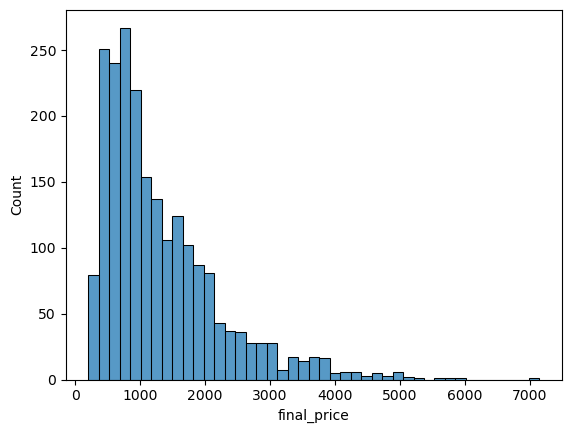

In [8]:
sns.histplot(df.final_price,)

There is a long tail distribution. Therefore, we have to compact the y values using logarithm

### Question 1

In [9]:
df.isnull().sum()

ram            0
storage        0
screen         4
final_price    0
dtype: int64

Screen has missing values

### Question 2

In [10]:
df.ram.describe().round(2)

count    2160.00
mean       15.41
std         9.87
min         4.00
25%         8.00
50%        16.00
75%        16.00
max       128.00
Name: ram, dtype: float64

The 50% percentile for ram is 16

### Data splitting

In [11]:
n = len(df)
n_val = int(n * 0.2)
n_test = int(n * 0.2)
n_train = n - n_val - n_test

In [12]:
idx = np.arange(n)

In [13]:
np.random.seed(42)
np.random.shuffle(idx)

In [14]:
df_train = df.iloc[idx[:n_train]]
df_val = df.iloc[idx[n_train:n_train + n_val]]
df_test = df.iloc[idx[n_train + n_val:]]

In [15]:
y_train = df_train.final_price
y_val = df_val.final_price
y_test = df_test.final_price

In [16]:
del df_train['final_price']
del df_val['final_price']
del df_test['final_price']

### Question 3

In [17]:
def prepare_X(df, filler=0):
    df = df.copy()
    df['screen'] = df['screen'].fillna(filler)

    X = df.values

    return X

In [18]:
def train_linear_regression(X, y):
    ones = np.ones(len(X))
    X = np.column_stack( (ones, X) )

    XTX = X.T.dot(X)
    XTX_inv = np.linalg.inv(XTX)

    w_full = XTX_inv.dot(X.T).dot(y)

    return w_full[0], w_full[1:]

In [19]:
screen_mean = df_train.screen.mean()

In [20]:
X_train = prepare_X(df_train)
X_train_mean = prepare_X(df_train, filler=screen_mean)

In [21]:
w0, w = train_linear_regression(X_train, y_train)
w0, w

(676.8954853013648, array([ 43.70681555,   0.86506867, -36.10399833]))

In [22]:
w0_mean, w_mean = train_linear_regression(X_train_mean, y_train)
w0_mean, w_mean

(808.9159907349447, array([ 43.90774584,   0.87135236, -45.18273312]))

In [23]:
def rmse(y_pred, y_val):
    se = (y_pred - y_val) ** 2
    mse = se.mean()
    rmse = np.sqrt(mse)

    return rmse

In [24]:
X_val = df_val.values

In [25]:
y_pred = w0 + X_val.dot(w)
y_pred_mean = w0_mean + X_val.dot(w_mean)

In [26]:
rmse(y_pred, y_val).round(2), rmse(y_pred_mean, y_val).round(2)

(596.96, 597.71)

Mean imputation is better

### Question 4

In [27]:
def prepare_X(df):
    df = df.copy()
    df = df.fillna(0)
    X = df.values

    return X

In [28]:
def train_linear_regression_reg(X, y, r=0.001):
    ones = np.ones(len(X))
    X = np.column_stack( (ones, X) )

    XTX = X.T.dot(X)
    XTX = XTX + r * np.eye(len(XTX))
    
    XTX_inv = np.linalg.inv(XTX)

    w_full = XTX_inv.dot(X.T).dot(y)

    return w_full[0], w_full[1:]

In [29]:
X_train = prepare_X(df_train)
X_val = prepare_X(df_val)

In [30]:
rs = [0, 0.01, 0.1, 1, 5, 10, 100]
for r in rs:
    w0, w = train_linear_regression_reg(X_train, y_train, r)
    y_pred = w0 + X_val.dot(w)
    score = rmse(y_pred, y_val).round(2)
    print(r, '-', score)

0 - 597.36
0.01 - 597.36
0.1 - 597.35
1 - 597.21
5 - 597.01
10 - 597.06
100 - 597.9


The smallest r with best rmse is 0.01 

### Question 5

In [31]:
seeds = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
scores = [ ]

In [32]:
for s in seeds:
    idx = np.arange(n)
    np.random.seed(s)
    np.random.shuffle(idx)

    df_train = df.iloc[idx[:n_train]]
    df_val = df.iloc[idx[n_train:n_train + n_val]]
    df_test = df.iloc[idx[n_train + n_val:]]
    
    y_train = df_train.final_price
    y_val = df_val.final_price
    y_test = df_test.final_price
    
    # y_train = np.log1p(y_train)
    # y_val = np.log1p(y_val)
    # y_test = np.log1p(y_test)
    
    del df_train['final_price']
    del df_val['final_price']
    del df_test['final_price']

    X_train = prepare_X(df_train)
    w0, w = train_linear_regression(X_train, y_train)

    X_val = prepare_X(df_val)
    y_pred = w0 + X_val.dot(w)

    score = rmse(y_pred, y_val)
    scores.append(score)

    print(s, score)

0 565.4520868770968
1 636.7985423056709
2 588.9558697907987
3 597.8148920012554
4 571.9627915111051
5 573.2383256618954
6 647.3438328407344
7 550.4398184485837
8 587.3335036169901
9 576.1017929433068


In [33]:
std = np.std(scores)

In [34]:
round(std, 3)

29.176

In [35]:
rmse_mean = np.array(scores).mean() * 0.1
rmse_mean

58.95441455997437

In [36]:
std / rmse_mean

0.4948991772043806

By courtesy of ChatGPT, if the relative standard deviation(RSD) is greater than 10%, then the model is not stable.

Since the RSD is approximately 49%, our model is not stable.

### Question 6

In [37]:
n_full_train = n - n_test

In [38]:
idx = np.arange(n)

In [39]:
np.random.seed(9)
np.random.shuffle(idx)

In [40]:
df_full_train = df.iloc[ idx[:n_full_train] ]
df_test = df.iloc[ idx[n_full_train:] ]

In [41]:
y_full_train = df_full_train.final_price
y_test = df_test.final_price

In [42]:
del df_full_train['final_price']
del df_test['final_price']

In [43]:
X_full_train = prepare_X(df_full_train)
w0, w = train_linear_regression_reg(X_full_train, y_full_train, r=0.001)

In [44]:
X_test = prepare_X(df_test)
y_pred = w0 + X_test.dot(w)

In [45]:
rmse(y_pred, y_test)

608.6099822049604